In [86]:
import yfinance as yf
import pandas as pd
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

# Reusable functions

In [62]:
def calculate_return(df):
    if df.empty:
        return None
    # Get the closing price at the start of the year
    start_price = df['Close'].iloc[0]
    
    # Get the closing price at the end of the year
    end_price = df['Close'].iloc[-1]
    
    # Calculate the one-year return
    return (end_price - start_price) / start_price

def MaximizeSharpeRatioOptmzn(MeanReturns, CovarReturns, RiskFreeRate, PortfolioSize):
     # define maximization of Sharpe Ratio using principle of duality
    def  f(x, MeanReturns, CovarReturns, RiskFreeRate, PortfolioSize):
        funcDenomr = np.sqrt(np.matmul(np.matmul(x, CovarReturns), x.T) )
        funcNumer = np.matmul(np.array(MeanReturns),x.T)-RiskFreeRate
        func = -(funcNumer / funcDenomr)
        return func

    #define equality constraint representing fully invested portfolio
    def constraintEq(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b 
        return constraintVal
    
    #define bounds and other parameters
    xinit=np.repeat(0.33, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq})
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])
    
    #invoke minimize solver
    opt = optimize.minimize (f, x0 = xinit, args = (MeanReturns, CovarReturns,\
                             RiskFreeRate, PortfolioSize), method = 'SLSQP',  \
                             bounds = bnds, constraints = cons, tol = 10**-3)
    
    return opt
    

In [63]:
largest_market_cap = pd.read_excel('./Top Companies by Market Cap.xlsx', sheet_name='Sheet1')
largest_market_cap

,Symbol,Company Name,Industry,Market Cap
0,AAPL,Apple Inc.,Consumer Electronics,"2,811.03B"
1,MSFT,Microsoft Corporation,Software - Infrastructure,"2,469.80B"
2,GOOGL,Alphabet Inc.,Internet Content & Information,"1,779.01B"
3,GOOG,Alphabet Inc.,Internet Content & Information,"1,778.79B"
4,AMZN,"Amazon.com, Inc.",Internet Retail,"1,360.20B"
...,...,...,...,...
495,RBLX,Roblox Corporation,Electronic Gaming & Multimedia,19.59B
496,WBA,"Walgreens Boots Alliance, Inc.",Pharmaceutical Retailers,19.51B
497,TW,Tradeweb Markets Inc.,Capital Markets,19.51B
498,ZM,"Zoom Video Communications, Inc.",Software - Application,19.51B


In [64]:
largest_market_cap = largest_market_cap[~largest_market_cap['Symbol'].str.contains('\.')].reset_index(drop=True)
top_300 = largest_market_cap.head(100)
top_300_symbols = top_300['Symbol']

In [65]:
# ticker = yf.Ticker('AAPL')
# stock_info = ticker.info
# print(stock_info.get('beta'))

In [66]:
one_year_data = {}
three_year_data = {}
five_year_data = {} 
for symbol in top_300_symbols:
    ticker = yf.Ticker(symbol)
    one_year_data[symbol] = ticker.history(period="1y")
    three_year_data[symbol] = ticker.history(period="3y")
    five_year_data[symbol] = ticker.history(period="5y")

In [67]:
one_year_return_data = {}
three_year_return_data = {}
five_year_return_data = {}
for key, df in one_year_data.items():
    one_year_return_data[key] = calculate_return(one_year_data[key])
    three_year_return_data[key] = calculate_return(three_year_data[key])
    five_year_return_data[key] = calculate_return(five_year_data[key])

In [68]:
filtered_data_one_year = {key: value for key, value in one_year_return_data.items() if value is not None and value >= 0.15 and value <= 0.8}
filtered_data_three_year = {key: value for key, value in three_year_return_data.items() if value is not None and value >= 0.10}
filtered_data_five_year = {key: value for key, value in five_year_return_data.items() if value is not None and value >= 0.10}

print(filtered_data_one_year.values())
print(filtered_data_three_year.values())
print(filtered_data_five_year.values())
overlapping_keys = set(filtered_data_one_year.keys()) & set(filtered_data_three_year.keys()) & set(filtered_data_five_year .keys())

dict_values([0.3001229342405525, 0.447742977442413, 0.42253525355569616, 0.4260135974055348, 0.21412527065972564, 0.22503531093159448, 0.31191968959202226, 0.44408532092722114, 0.24416840915969312, 0.37073155358596205, 0.3871576335724418, 0.18707175944906795, 0.7088244851141176, 0.15919878141608512, 0.2561649537803035, 0.324882498450057, 0.5983983327461118, 0.15064366619694308, 0.3855724224424731, 0.3785622191440767, 0.2507871208190861, 0.3426759063170163, 0.43854587668297834, 0.213300844077826, 0.7289288498376517, 0.3919855750693312, 0.5007318409553644, 0.5464347507642663, 0.6281536400248436, 0.3945395517853608, 0.5474634570349849, 0.43513807731660054, 0.41258623966357333, 0.16838748430543027, 0.1555847347509657, 0.2045448678116866, 0.5367854269777068, 0.42952280577328844, 0.2791187805923465, 0.21143150165271393, 0.2815058222899161, 0.3887346011135765, 0.6083215046765759, 0.3772141576884442, 0.16231465792444863, 0.7659968604248233, 0.19407966991261863, 0.3257044539246005])
dict_values

In [69]:
len(overlapping_keys)

34

In [70]:
betas = {}
for key in overlapping_keys:
    betas[key] = yf.Ticker(key).info.get('beta')
filtered_beta = {key: value for key, value in betas.items() if value is not None and value > 0.70 and value <= 1.50}
print(len(filtered_beta))


19


In [71]:
df_filtered_beta_keys = pd.DataFrame(list(filtered_beta.keys()), columns=['Symbol'])
df_filtered_beta_keys

,Symbol
0,ASML
1,GOOG
2,ACN
3,AAPL
4,SONY
5,INTU
6,V
7,MA
8,BX
9,TTE


In [72]:
merged_df = pd.merge(df_filtered_beta_keys, largest_market_cap, on='Symbol', how='left')
merged_df

,Symbol,Company Name,Industry,Market Cap
0,ASML,ASML Holding N.V.,Semiconductor Equipment & Materials,238.48B
1,GOOG,Alphabet Inc.,Internet Content & Information,"1,778.79B"
2,ACN,Accenture plc,Information Technology Services,196.59B
3,AAPL,Apple Inc.,Consumer Electronics,"2,811.03B"
4,SONY,Sony Group Corporation,Consumer Electronics,105.39B
5,INTU,Intuit Inc.,Software - Application,151.78B
6,V,Visa Inc.,Credit Services,490.17B
7,MA,Mastercard Incorporated,Credit Services,373.76B
8,BX,Blackstone Inc.,Asset Management,130.52B
9,TTE,TotalEnergies SE,Oil & Gas Integrated,156.18B


### Semiconductor Equipment & Materials: ASML Holding N.V. (ASML)
### Internet Content & Information: Alphabet Inc. (GOOG or GOOGL)
### Information Technology Services: Accenture plc (ACN)
### Consumer Electronics: Apple Inc. (AAPL)
### Software - Application: Intuit Inc. (INTU)
### Credit Services: Visa Inc. (V)
### Asset Management: Blackstone Inc. (BX)
### Oil & Gas Integrated: TotalEnergies SE (TTE)
### Travel Services: Booking Holdings Inc. (BKNG)
### Software - Infrastructure: Microsoft Corporation (MSFT)

# Pull past 1 years' data and calculate their daily actual returns

In [74]:
stocks = ["ASML", "GOOG", "ACN", "AAPL", "INTU", "V", "BX", "TTE", "BKNG", "MSFT"]

In [112]:
daily_actual_returns = {}
for s in stocks:
    daily_actual_returns[s] = one_year_data[s]['Close'].pct_change(1).dropna()

In [113]:
combined_daily_actual_returns = pd.concat(daily_actual_returns, axis=1)
combined_daily_actual_returns

,ASML,GOOG,ACN,AAPL,INTU,V,BX,TTE,BKNG,MSFT
Date,,,,,,,,,,
2022-10-17 00:00:00-04:00,0.034526,0.037045,0.037591,0.029123,0.062166,0.014402,0.048859,0.011765,0.046094,0.039246
2022-10-18 00:00:00-04:00,0.017261,0.006053,0.006979,0.009409,0.012161,0.010364,0.021421,-0.001550,0.015147,0.004084
2022-10-19 00:00:00-04:00,0.062733,-0.010849,0.000038,0.000765,-0.016102,-0.004060,-0.026409,0.010481,-0.001206,-0.008470
2022-10-20 00:00:00-04:00,0.031249,0.002393,-0.008634,-0.003267,-0.002288,0.004345,-0.042170,-0.004034,0.001016,-0.001395
2022-10-21 00:00:00-04:00,0.057082,0.009450,0.029758,0.027059,0.039960,0.016825,0.016540,0.006365,0.027723,0.025280
...,...,...,...,...,...,...,...,...,...,...
2023-10-09 00:00:00-04:00,-0.010027,0.005550,-0.000577,0.008451,0.003019,-0.002553,-0.003044,0.016878,-0.013025,0.007823
2023-10-10 00:00:00-04:00,0.018229,-0.002151,0.000994,-0.003352,0.009721,0.009213,0.004580,0.006762,0.016839,-0.004336
2023-10-11 00:00:00-04:00,0.006709,0.017960,0.004855,0.007904,0.002722,-0.003888,0.018805,0.003206,0.003774,0.012272


In [124]:
five_year_expected_returns = combined_daily_actual_returns.mean().to_frame(name='Annual Expected Return')*252
five_year_expected_returns['Annual Expected Return'].to_frame().T

,ASML,GOOG,ACN,AAPL,INTU,V,BX,TTE,BKNG,MSFT
Annual Expected Return,0.545286,0.415824,0.230998,0.300016,0.41228,0.292181,0.327892,0.364159,0.611705,0.416994


In [122]:
five_year_std_dev = np.sqrt(combined_daily_actual_returns.var().to_frame(name='Standard Deviation')*252)
five_year_std_dev['Standard Deviation'].to_frame().T

,ASML,GOOG,ACN,AAPL,INTU,V,BX,TTE,BKNG,MSFT
Standard Deviation,0.383251,0.340842,0.269441,0.26738,0.358395,0.19258,0.401834,0.240444,0.276205,0.297312


,ASML,GOOG,ACN,AAPL,INTU,V,BX,TTE,BKNG,MSFT
ASML,0.000583,0.000279,0.000251,0.000250,0.000326,0.000153,0.000300,0.000089,0.000198,0.000275
GOOG,0.000279,0.000461,0.000198,0.000233,0.000305,0.000104,0.000257,0.000032,0.000146,0.000285
ACN,0.000251,0.000198,0.000288,0.000173,0.000245,0.000111,0.000247,0.000051,0.000106,0.000196
AAPL,0.000250,0.000233,0.000173,0.000284,0.000228,0.000122,0.000233,0.000046,0.000106,0.000210
INTU,0.000326,0.000305,0.000245,0.000228,0.000510,0.000153,0.000324,0.000062,0.000177,0.000269
V,0.000153,0.000104,0.000111,0.000122,0.000153,0.000147,0.000163,0.000065,0.000086,0.000091
BX,0.000300,0.000257,0.000247,0.000233,0.000324,0.000163,0.000641,0.000098,0.000197,0.000253
TTE,0.000089,0.000032,0.000051,0.000046,0.000062,0.000065,0.000098,0.000229,0.000080,0.000037
BKNG,0.000198,0.000146,0.000106,0.000106,0.000177,0.000086,0.000197,0.000080,0.000303,0.000117
MSFT,0.000275,0.000285,0.000196,0.000210,0.000269,0.000091,0.000253,0.000037,0.000117,0.000351


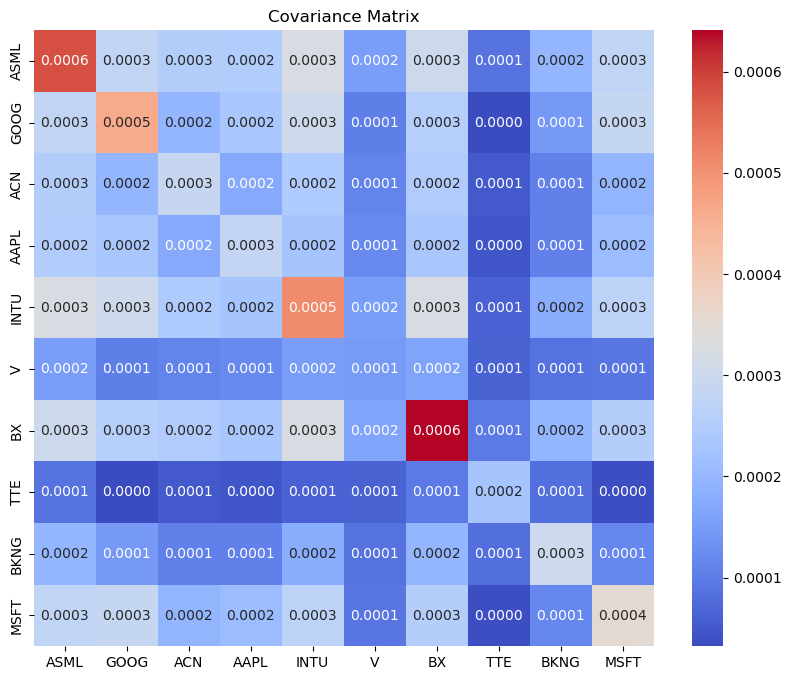

In [117]:
cov_matrix = combined_daily_actual_returns.cov()
display(cov_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt='.4f')
plt.title("Covariance Matrix")
plt.show()

### Get the 30 years Treasury Bond

In [95]:
tyx = yf.Ticker("^TYX")

# Get the historical data (most recent data)
data = tyx.history(period="5d")

# Extract the close value, which represents the yield
latest_yield = data['Close'].iloc[0]

print(f"Current 30-year Treasury bond yield: {latest_yield}%")

Current 30-year Treasury bond yield: 4.830999851226807%
